# PyTorch图像操作

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from torchvision import transforms as tfs

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## 卷积

### 读入图片

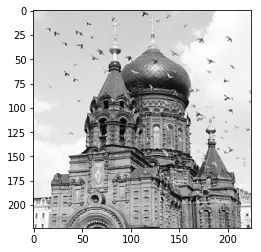

In [2]:
im = Image.open('./example_data/sofia.png').convert('L') # 读入一张灰度图的图片
im = np.array(im, dtype='float32') # 将其转换为一个矩阵

# 可视化图片
plt.imshow(im.astype('uint8'), cmap='gray')

In [3]:
# 将图片矩阵转化为 pytorch tensor，并适配卷积输入的要求
im = torch.from_numpy(im.reshape((1, 1, im.shape[0], im.shape[1]))) 

In [4]:
# 使用 nn.Conv2d
conv1 = nn.Conv2d(1, 1, 3, bias=False) # 定义卷积

sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
conv1.weight.data = torch.from_numpy(sobel_kernel) # 给卷积的 kernel 赋值

edge1 = conv1(Variable(im)) # 作用在图片上
edge1 = edge1.data.squeeze().numpy() # 将输出转换为图片的格式

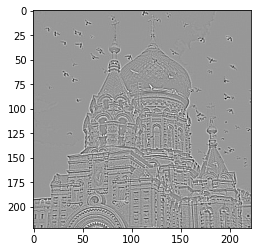

In [5]:
plt.imshow(edge1, cmap='gray')

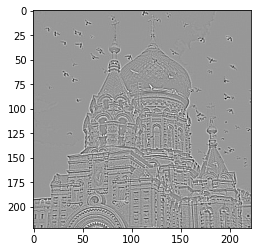

In [6]:
# 使用 F.conv2d
sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
weight = Variable(torch.from_numpy(sobel_kernel))

edge2 = F.conv2d(Variable(im), weight) # 作用在图片上
edge2 = edge2.data.squeeze().numpy() # 将输出转换为图片的格式
plt.imshow(edge2, cmap='gray')

## 池化

before max pool, image shape: 224 x 224
after max pool, image shape: 28 x 28 


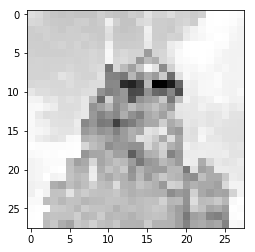

In [7]:
# 使用 nn.MaxPool2d
pool1 = nn.MaxPool2d(8, 8)
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im1 = pool1(Variable(im))
small_im1 = small_im1.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))
plt.imshow(small_im1, cmap='gray')

before max pool, image shape: 224 x 224
after max pool, image shape: 28 x 28 


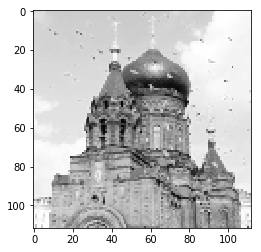

In [8]:
# F.max_pool2d
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im2 = F.max_pool2d(Variable(im), 2, 2)
small_im2 = small_im2.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))
plt.imshow(small_im2, cmap='gray')

## 数据增强

### 常用的数据增强方法
常用的数据增强方法如下：  
1.对图片进行一定比例缩放  
2.对图片进行随机位置的截取   
3.对图片进行随机的水平和竖直翻转  
4.对图片进行随机角度的旋转  
5.对图片进行亮度、对比度和颜色的随机变化

这些方法 pytorch 都已经为我们内置在了 torchvision 里面，我们在安装 pytorch 的时候也安装了 torchvision，下面我们来依次展示一下这些数据增强方法

In [9]:
import sys
sys.path.append('..')

from PIL import Image
from torchvision import transforms as tfs

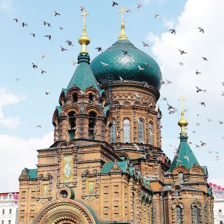

In [10]:
# 读入一张图片
im = Image.open('./example_data/sofia.png')
im

### 随机比例放缩
随机比例缩放主要使用的是 `torchvision.transforms.Resize()` 这个函数，第一个参数可以是一个整数，那么图片会保存现在的宽和高的比例，并将更短的边缩放到这个整数的大小，第一个参数也可以是一个 tuple，那么图片会直接把宽和高缩放到这个大小；第二个参数表示放缩图片使用的方法，比如最邻近法，或者双线性差值等，一般双线性差值能够保留图片更多的信息，所以 pytorch 默认使用的是双线性差值，你可以手动去改这个参数，更多的信息可以看看[文档](http://pytorch.org/docs/0.3.0/torchvision/transforms.html)

before scale, shape: (224, 224)
after scale, shape: (200, 100)


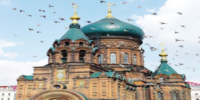

In [11]:
# 比例缩放
print('before scale, shape: {}'.format(im.size))
new_im = tfs.Resize((100, 200))(im)
print('after scale, shape: {}'.format(new_im.size))
new_im

### 随机位置截取
随机位置截取能够提取出图片中局部的信息，使得网络接受的输入具有多尺度的特征，所以能够有较好的效果。在 torchvision 中主要有下面两种方式，一个是 `torchvision.transforms.RandomCrop()`，传入的参数就是截取出的图片的长和宽，对图片在随机位置进行截取；第二个是 `torchvision.transforms.CenterCrop()`，同样传入介曲初的图片的大小作为参数，会在图片的中心进行截取

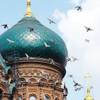

In [12]:
# 随机裁剪出 100 x 100 的区域
random_im1 = tfs.RandomCrop(100)(im)
random_im1

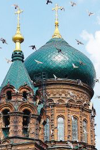

In [13]:
# 随机裁剪出 150 x 100 的区域
random_im2 = tfs.RandomCrop((150, 100))(im)
random_im2

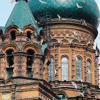

In [14]:
# 中心裁剪出 100 x 100 的区域
center_im = tfs.CenterCrop(100)(im)
center_im

### 随机的水平和竖直方向翻转
对于上面这一张猫的图片，如果我们将它翻转一下，它仍然是一张猫，但是图片就有了更多的多样性，所以随机翻转也是一种非常有效的手段。在 torchvision 中，随机翻转使用的是 `torchvision.transforms.RandomHorizontalFlip()` 和 `torchvision.transforms.RandomVerticalFlip()`

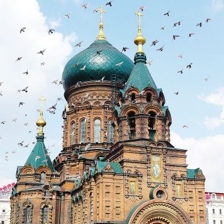

In [15]:
# 随机水平翻转
h_filp = tfs.RandomHorizontalFlip()(im)
h_filp

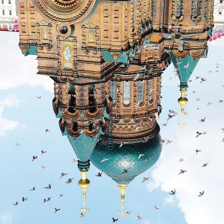

In [16]:
# 随机竖直翻转
v_flip = tfs.RandomVerticalFlip()(im)
v_flip

### 随机角度旋转
一些角度的旋转仍然是非常有用的数据增强方式，在 torchvision 中，使用 `torchvision.transforms.RandomRotation()` 来实现，其中第一个参数就是随机旋转的角度，比如填入 10，那么每次图片就会在 -10 ~ 10 度之间随机旋转

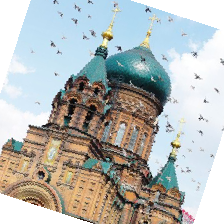

In [17]:
rot_im = tfs.RandomRotation(45)(im)
rot_im

### 亮度、对比度和颜色的变化
除了形状变化外，颜色变化又是另外一种增强方式，其中可以设置亮度变化，对比度变化和颜色变化等，在 torchvision 中主要使用 `torchvision.transforms.ColorJitter()` 来实现的，第一个参数就是亮度的比例，第二个是对比度，第三个是饱和度，第四个是颜色

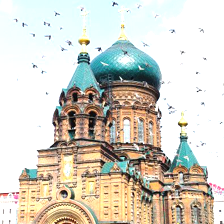

In [18]:
# 亮度
bright_im = tfs.ColorJitter(brightness=1)(im) # 随机从 0 ~ 2 之间亮度变化，1 表示原图
bright_im

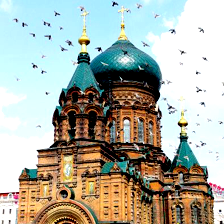

In [19]:
# 对比度
contrast_im = tfs.ColorJitter(contrast=1)(im) # 随机从 0 ~ 2 之间对比度变化，1 表示原图
contrast_im

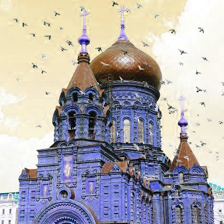

In [20]:
# 颜色
color_im = tfs.ColorJitter(hue=0.5)(im) # 随机从 -0.5 ~ 0.5 之间对颜色变化
color_im



上面我们讲了这么图片增强的方法，其实这些方法都不是孤立起来用的，可以联合起来用，比如先做随机翻转，然后随机截取，再做对比度增强等等，torchvision 里面有个非常方便的函数能够将这些变化合起来，就是 `torchvision.transforms.Compose()`，下面我们举个例子

In [21]:
im_aug = tfs.Compose([
    tfs.Resize(120),
    tfs.RandomHorizontalFlip(),
    tfs.RandomCrop(96),
    tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5)
])

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

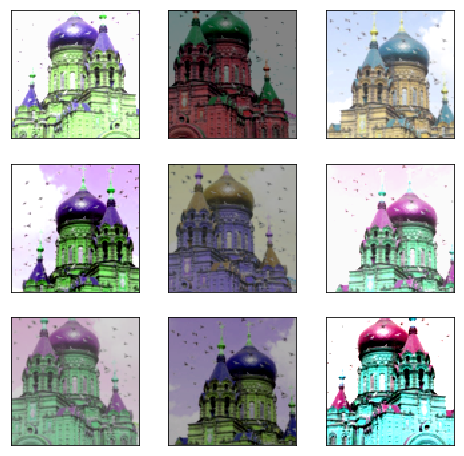

In [23]:
nrows = 3
ncols = 3
figsize = (8, 8)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(im_aug(im))
        figs[i][j].axes.get_xaxis().set_visible(False)
        figs[i][j].axes.get_yaxis().set_visible(False)
plt.show()